# Case - Previsão do preço de custo do seguro com modelos de regressão

## Objetivo do projeto

Desenvolver o melhor modelo de machine learning de regressão para calcular o custo do seguro de clientes de uma empresa.

## Análise dos dados

### Leitura e primeira visualização do dataset

Primeiro, importou-se o dataset,

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_excel('insurance.xlsx')
df.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Pela análise acima, percebe-se que o dataset apresenta 7 colunas, sendo elas:
- idade
- sexo
- imc = índice de massa corporal
- quantidade de filhos
- fumante
- região
- custos do seguro

Portanto, a variável "target" deste projeto se trata da "custos_seguro", sendo as demais variáveis explicativas.

### Dados nulos

Analisando-se mais afundo o dataset,

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1341 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1341 non-null   float64
 3   quantidade_filhos  1341 non-null   int64  
 4   fumante            1341 non-null   object 
 5   regiao             1341 non-null   object 
 6   custos_seguro      1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


Pelo resultado acima percebe-se que na coluna 'sexo' tem-se 3 entradas com dados nulos. Para calcular esta quantidade e o percentual comparado ao total de entradas (1341), utilizou-se o código abaixo.

In [22]:
missing_data = (
    df.isnull().sum().to_frame('missing_count')
    .join(((df.isnull().sum())/(df.shape[0])).to_frame('missing_pct'))
)

missing_data.style.format('{:.2%}', subset='missing_pct')

,missing_count,missing_pct
idade,0,0.00%
sexo,3,0.22%
imc,0,0.00%
quantidade_filhos,0,0.00%
fumante,0,0.00%
regiao,0,0.00%
custos_seguro,0,0.00%


Conforme demonstrado acima, como o percentual de linhas com dados nulos é muito baixo (0,22%), optou-se por excluí-las do dataset.

In [23]:
# excluindo os dados nulos
df.dropna(inplace = True)

### Linhas duplicadas

Verificando agora a possível existência de linhas duplicadas,

In [24]:
df.duplicated().sum()

1

Exibindo as duas linhas iguais presentes no dataset,

In [25]:
df[df.duplicated(keep = False)]

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


Como são apenas duas linhas duplicadas, para evitar problemas no modelo, optou-se por excluí-las também.

In [26]:
df.drop_duplicates(inplace=True)

### Estatísticas descritivas e outliers

Avaliando agora as estatísticas descritivas das colunas numéricas presentes no dataset.

In [27]:
df.describe()

,idade,imc,quantidade_filhos,custos_seguro
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663871,1.095737,13279.121487
std,14.044333,6.100648,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Observando os dados de custos de seguro acima, percebe-se um desvio padrão de 12110, este que é um valor alto se comparado a média de 13279.12. Avalindo-se os quartis, é possível perceber que 75% dos preços de seguro são de até 16657, contudo o valor máximo presente nesta coluna é de 63770.42, indicando que provalvemente tem-se poucos valores altos de seguro que estão puxando o desvio padrão para cima, explicando esta distribuição de dados e também podendo significar a existência de outliers.

Para visualizar a distribuição destes dados, plotou-se o histograma abaixo.

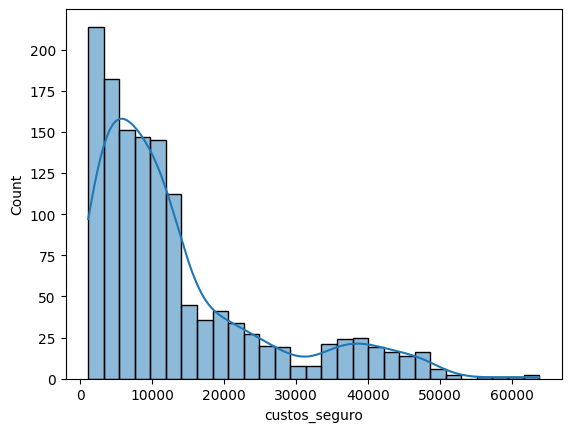

In [28]:
sns.histplot(data = df, x = 'custos_seguro', kde = True);

Pelo gráfico acima, tem-se uma distribuição com assimetria positiva destes dados, onde a média é maior que a mediana e a moda, o que leva aos dados com valores mais altos serem bem menos frequentes. Fica claro pelo pela imagem que os casos com custo de seguro de 50000 ou mais são muito raros neste dataset. Para mostrar estes casos, segue o código abaixo

In [29]:
df[df['custos_seguro']>=50000]

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1302,45,male,30.360,0,yes,southeast,62592.87309


Portanto, são apenas 7 casos em que o custo do seguro foi acima dos 50000.

Verificou-se agora a existência de outliers neste dataset. Para tal, foi definida função abaixo, que calcula a quantidade de outliers por coluna.

In [30]:
# função para calcular a quantidade de outliers
def is_outlier (array):
    q1, q3 = np.quantile(array, [0.25, 0.75])
    iqr = q3-q1

    upper_outlier = q3 + 1.5*iqr
    lower_outlier = q1 - 1.5*iqr

    return ((array<lower_outlier) | (array>upper_outlier))

Em seguida, aplicou-se a função em cada coluna do dataset, plotando-se os gráficos boxplot somente das colunas que tem outliers.

In [40]:
# definindo um data frame com a quantidade de outliers por coluna

outliers_df = (df.select_dtypes('number')                       # selecionando somente as colunas numéricas
               .apply(is_outlier)                               # aplicando a função definida anteriormente
               .sum()                                           # calculando o total de outliers presentes na coluna
               .reset_index()                                   # adicionando uma nova coluna 'index' na Series, criando assim um Data Frame
               .rename(columns = {                              # renomeando as colunas do novo Data Frame
                   'index': 'colunas_df',
                   0: 'quantidade_outliers'
                })
)

outliers_df

,colunas_df,quantidade_outliers
0,idade,0
1,imc,9
2,quantidade_filhos,0
3,custos_seguro,139


In [42]:
# criando uma lista somente com o nome das colunas que apresentam outliers

colunas_outliers = outliers_df[outliers_df['quantidade_outliers']>0]['colunas_df'].to_list()
colunas_outliers

['imc', 'custos_seguro']

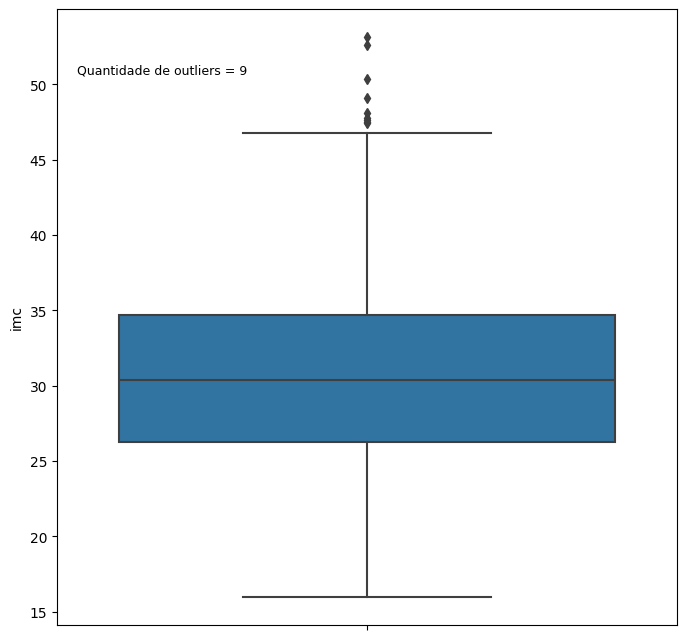

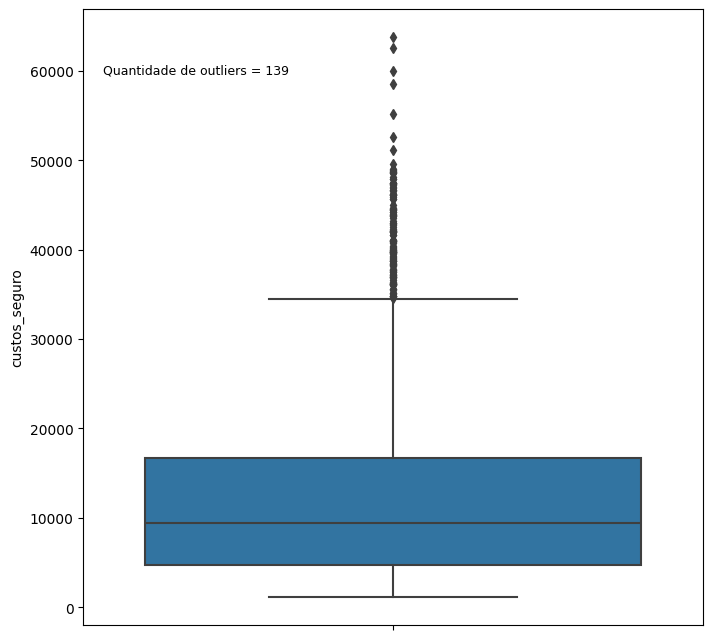

In [44]:
# plotando um gráfico boxplot por coluna que está na lista criada anteriormente

for coluna in colunas_outliers:

    # ajustando o tamanho da imagem dos gráficos
    figura = plt.figure(figsize = (8,8))
    
    # plotando o gráfico
    sns.boxplot(y = df[coluna])
    
    # salvando a quantidade de outliers presentes na coluna
    qtd_outliers = outliers_df[outliers_df['colunas_df'] == coluna]['quantidade_outliers'].to_numpy()[0]
    
    # criando um texto auxiliar para ser exibido junto com o gráfico, mostrando a quantidade de outliers
    legenda = f'Quantidade de outliers = {qtd_outliers}'

    # ajustando a posição e cor do texto no gráfico
    figura.text(0.15, 0.8, legenda, size = 9, color='black')

    # exibindo os gráficos
    plt.show()

Portanto, pelos gráficos acima percebe-se que as colunas "custos_seguro" e "imc" são as únicas que apresentam outliers, sendo em custos os casos mais frequentes com 139 outliers, existindo apenas 9 na coluna 'imc'.

Para tratar casos de outliers, 

poderia-se apenas ignorá-los, aplicando-se um filtro no dataset em que serão ignorados os casos em que a função definida acima 'is_outlier' retorna "True". Isto é demonstrado a seguir.

In [45]:
# filtrando o dataset para ignorar todas as linhas que contenham outliers

df[~df.select_dtypes('number').apply(is_outlier).any(axis = 1)]

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1336,50,male,30.970,3,no,northwest,10600.54830
1337,18,female,31.920,0,no,northeast,2205.98080
1338,18,female,36.850,0,no,southeast,1629.83350
1339,21,female,25.800,0,no,southwest,2007.94500


### Tratando as variáveis categóricas

In [13]:
df['regiao'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [14]:
df['sexo'].unique()

array(['female', 'male'], dtype=object)

In [15]:
df['fumante'].unique()

array(['yes', 'no'], dtype=object)

In [16]:
df = pd.get_dummies(df, columns = ['regiao', 'sexo', 'fumante'], dtype = 'int')
df.head()

,idade,imc,quantidade_filhos,custos_seguro,regiao_northeast,regiao_northwest,regiao_southeast,regiao_southwest,sexo_female,sexo_male,fumante_no,fumante_yes
0,19,27.900,0,16884.92400,0,0,0,1,1,0,0,1
1,18,33.770,1,1725.55230,0,0,1,0,0,1,1,0
2,28,33.560,3,4449.46200,0,0,1,0,0,1,1,0
3,33,22.705,0,21984.47061,0,1,0,0,0,1,1,0
4,32,28.880,0,3866.85520,0,1,0,0,0,1,1,0
